# AutoEncoding Neural Network on MNIST

## Imports and Data Loading

In [1]:
from __future__ import print_function
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

batchsize = 128
epochs=25
loginterval=10

SEED = 1
torch.manual_seed(SEED)
cuda = torch.cuda.is_available()

#device = torch.device("cuda" if cuda else "cpu")
device = torch.device("cpu")



kwargs = {'num_workers': 4, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

## Model Definition

### Model 1 : Simple AE

We chose to work with the following configuration :

* Fully Connected Layers (784,400) and (400,20) with a ReLu activation fuction,
* The Loss Function considered is a BCE,
* The Encoder and the Decoder are symmetric.

In [2]:
class simple_ae(nn.Module):
    def __init__(self):
        super(simple_ae, self).__init__()
        # encoder :FC (784 -> 400), RELU activation; FC (400, 20)
        self.encoder = nn.Sequential(
                nn.Linear(784, 400),
                nn.ReLU(),
                nn.Linear(400, 20),
                )
        # decoder :FC (20 -> 400), RELU activation; FC (400, 784)
        self.decoder = nn.Sequential(
                nn.Linear(20, 400),
                nn.ReLU(),
                nn.Linear(400, 784),
                )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        xview = x.view(-1,784)
        z = self.encode(xview)
        return self.decode(z)

mod1 = simple_ae()
optimizer = optim.Adam(mod1.parameters(), lr=1e-3)

In [4]:
def loss_function_bce(recon_batch, x):
    #compute bce as the binary cross entropy across the batch as a sum
    bce = nn.BCELoss(size_average=False)
    return bce(recon_batch, x)

writing_path1="../generated_ae/mod1/"
os.system("mkdir -p %s"%writing_path1)
losses=list()

### Model 2 : A more elaborated AE

We chose to work with the following configuration :

* Fully Connected Layers (784,128), (128,128), (128,16) and (16,4) with a ReLu activation fuction,
* The Loss Function considered is a MSE,
* The Encoder and the Decoder are symmetric.

In [13]:
class elab_ae(nn.Module):
    def __init__(self):
        super(elab_ae, self).__init__()
        # create using nn.Sequential()
        # encoder :FC (784 -> 400), RELU activation; FC (400, 20)
        # decoder :FC (20 -> 400), RELU activation; FC (400, 784)
        self.encoder = nn.Sequential(
                nn.Linear(784, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128,16),
                nn.ReLU(),
                nn.Linear(16,4)
                )
        self.decoder = nn.Sequential(
                nn.Linear(4, 16),
                nn.ReLU(),
                nn.Linear(16, 128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,784)
                )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        xview = x.view(-1,784)
        z = self.encode(xview)
        return self.decode(z)

mod2 = elab_ae()
optimizer = optim.Adam(mod2.parameters(), lr=1e-3)

In [14]:
def loss_function_mse(recon_batch, x):
    #compute bce as the bin0ary cross entropy across the batch as a sum
    mse = nn.MSELoss(size_average=False)
    return mse(recon_batch, x)

writing_path2="../generated_ae/mod2/"
os.system("mkdir -p %s"%writing_path2)
losses,losses_bup=list(),losses

## Definition of Train and Test functions

In [3]:
def train(epoch,model,l_function):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = l_function(recon_batch, data.view(-1, 784))
        losses.append(loss.to(device).item())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % loginterval == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.1f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), end='')

    print(' Average loss: {:.1f}'.format(
          train_loss / len(train_loader.dataset)), end='')

def test(epoch,writing_path,model,l_function):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += l_function(recon_batch, data.view(-1, 784))

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batchsize, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         writing_path + 'reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(' Test loss: {:.1f}'.format(test_loss))

## Training Phase and Losses tracking

### Model 1 :

In [6]:
for epoch in range(1, epochs + 1):
    train(epoch,mod1,loss_function_bce)
    test(epoch,writing_path1,mod1,loss_function_bce)
    with torch.no_grad():
     sample = torch.randn(64, 20).to(device)
     sample = mod1.decode(sample).cpu()
     save_image(sample.view(64, 1, 28, 28), writing_path1 + 'sample_' + str(epoch) + '.png')

 Train Epoch: 1 [58880/60000 (98%)]	Loss: 84.5 Average loss: 83.4 Test loss: 78.2
 Train Epoch: 2 [58880/60000 (98%)]	Loss: 77.0 Average loss: 77.0 Test loss: 74.5
 Train Epoch: 3 [58880/60000 (98%)]	Loss: 76.2 Average loss: 74.2 Test loss: 72.6
 Train Epoch: 4 [58880/60000 (98%)]	Loss: 73.3 Average loss: 72.4 Test loss: 71.4
 Train Epoch: 5 [58880/60000 (98%)]	Loss: 69.6 Average loss: 71.2 Test loss: 70.3
 Train Epoch: 6 [58880/60000 (98%)]	Loss: 69.8 Average loss: 70.2 Test loss: 69.5
 Train Epoch: 7 [58880/60000 (98%)]	Loss: 71.3 Average loss: 69.4 Test loss: 68.9
 Train Epoch: 8 [58880/60000 (98%)]	Loss: 68.5 Average loss: 68.8 Test loss: 68.5
 Train Epoch: 9 [58880/60000 (98%)]	Loss: 69.3 Average loss: 68.3 Test loss: 68.1
 Train Epoch: 10 [58880/60000 (98%)]	Loss: 67.3 Average loss: 67.9 Test loss: 67.7
 Train Epoch: 11 [58880/60000 (98%)]	Loss: 69.2 Average loss: 67.5 Test loss: 67.3
 Train Epoch: 12 [58880/60000 (98%)]	Loss: 66.9 Average loss: 67.1 Test loss: 67.1
 Train Epoch:

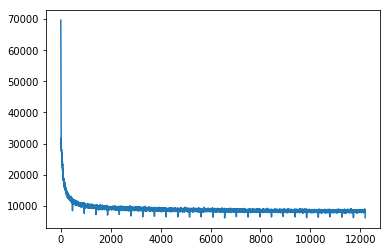

In [7]:
plt.plot(losses)

### Model 2 :

In [16]:
for epoch in range(1, epochs + 1):
    train(epoch,mod2,loss_function_mse)
    test(epoch,writing_path2,mod2,loss_function_mse)
    with torch.no_grad():
     sample = torch.randn(64, 4).to(device)
     sample = mod2.decode(sample).cpu()
     save_image(sample.view(64, 1, 28, 28), writing_path2 + 'sample_' + str(epoch) + '.png')

 Train Epoch: 1 [58880/60000 (98%)]	Loss: 29.8 Average loss: 34.1 Test loss: 30.8
 Train Epoch: 2 [58880/60000 (98%)]	Loss: 28.6 Average loss: 29.5 Test loss: 28.3
 Train Epoch: 3 [58880/60000 (98%)]	Loss: 25.1 Average loss: 27.6 Test loss: 26.9
 Train Epoch: 4 [58880/60000 (98%)]	Loss: 28.8 Average loss: 26.5 Test loss: 26.1
 Train Epoch: 5 [58880/60000 (98%)]	Loss: 25.6 Average loss: 25.7 Test loss: 25.4
 Train Epoch: 6 [58880/60000 (98%)]	Loss: 22.9 Average loss: 25.1 Test loss: 24.8
 Train Epoch: 7 [58880/60000 (98%)]	Loss: 25.1 Average loss: 24.6 Test loss: 24.3
 Train Epoch: 8 [58880/60000 (98%)]	Loss: 22.3 Average loss: 24.2 Test loss: 24.0
 Train Epoch: 9 [58880/60000 (98%)]	Loss: 21.4 Average loss: 23.8 Test loss: 23.7
 Train Epoch: 10 [58880/60000 (98%)]	Loss: 22.6 Average loss: 23.5 Test loss: 23.5
 Train Epoch: 11 [58880/60000 (98%)]	Loss: 23.4 Average loss: 23.3 Test loss: 23.2
 Train Epoch: 12 [58880/60000 (98%)]	Loss: 23.2 Average loss: 23.0 Test loss: 23.1
 Train Epoch:

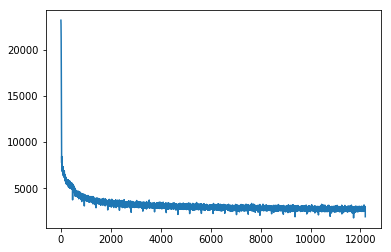

In [17]:
plt.plot(losses)